In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
from tqdm import tqdm_notebook
import regex as re

In [3]:
IUPAC_WILDCARDS = {
    "W" : "AT",
    "S" : "CG",
    "M" : "AC",
    "K" : "GT",
    "R" : "AG",
    "Y" : "CT",
    "B" : "CGT",
    "D" : "AGT",
    "H" : "ACT",
    "V" : "ACG",
    "N" : "ACGT",
}

In [4]:
def read_fastq(path):
    with open(path) as f:
        lines = f.readlines()
    
    reads = [x[:-1] for x in lines[1::4]]
    qualities = [x[:-1] for x in lines[3::4]]
    
    return reads, qualities

In [5]:
def repeat_to_re_pattern(repeat, e=2, d = IUPAC_WILDCARDS):
    re_pattern = "("
    for char in repeat:
        if char not in d.keys() and char != '(' and char != ')':
            re_pattern += char
        elif char in d.keys():
            re_pattern += "[" +  "|".join(d[char]) + "]"
    
    re_pattern += "){e<=" + str(e) + "}"
    return re_pattern

In [6]:
def find(repeat, read, e = 2):
    p_str = repeat_to_re_pattern(repeat,e=e)
    p = re.compile(p_str)
   
    return [x.span() for x in re.finditer(p, read)]

In [7]:
def split_read(read, quality, repeat, repeat_s, repeat_e, e=2, v=0):
    repeat_pos = find(repeat, read, e)
    
    if v: print(repeat_pos)
    if len(repeat_pos) == 0:
        return [-1, -1], [-1, -1]

    else:
        repeat_pos = repeat_pos[0]
        read_left = read[:repeat_pos[0]]
        q_left = quality[:repeat_pos[0]]
        
        read_right = read[repeat_pos[1]:]
        q_right = quality[repeat_pos[1]:]
        
        
        repeat_pos_l = find(repeat_e, read_left, e)
        if v: print(repeat_pos_l)
        if len(repeat_pos_l) == 0:
            left_spacer = -1
            left_sp_q = -1
        else:
            left_spacer = read_left[repeat_pos_l[0][1]:]
            left_sp_q = q_left[repeat_pos_l[0][1]:]
            
        
        repeat_pos_r = find(repeat_s, read_right, e)
        if v: print(repeat_pos_r)
        if len(repeat_pos_r) == 0:
            right_spacer = -1
            right_sp_q = -1
        else:
            right_spacer = read_right[:repeat_pos_r[0][0]]
            right_sp_q = q_right[:repeat_pos_r[0][0]]
        
        return [left_spacer, right_spacer], [left_sp_q, right_sp_q]

In [32]:
quality_symbols1 = r'!"#$%&' 
quality_symbols2 = "'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~"

In [43]:
quality_dict = {}
quality_dict_r = {}
for i, char in enumerate(quality_symbols1 + quality_symbols2):
    quality_dict[char] = i
    quality_dict_r[i] = char

In [35]:
get_quality = lambda x: quality_dict[x]

In [47]:
def get_lowest_q(pair_q, gq = get_quality):
    return quality_dict[min(pairs_q[123][0] + pairs_q[123][1], key=gq)]

In [8]:
path = "../data/clostr_test/fastq/Polina-1_S11_L001_R1_001.fastq"

In [9]:
repeat = "GTTTTAKATTA(ACTAWRTGG)WATGTAAAK"
repeat_s = "GTTTTAKATTAACTAWRTGG"
repeat_e = "ACTAWRTGGWATGTAAAK"

repeat_clear = "GTTTTAKATTAACTAWRTGGWATGTAAAK"

In [18]:
reads, qualities = read_fastq(path)

In [20]:
pairs, pairs_q = [], []
for r,q in tqdm_notebook(zip(reads, qualities)):
    p, pq = split_read(r, q, repeat, repeat_s, repeat_e)
    pairs.append(p)
    pairs_q.append(pq)

In [22]:
pairs = np.array(pairs)
pairs_q = np.array(pairs_q)

In [25]:
mask = np.array(['-1' not in pair for pair in tqdm_notebook(pairs)])

print(mask.sum())

pairs = pairs[mask]
pairs_q = pairs_q[mask]

A Jupyter Widget


28815


In [53]:
min_pq = np.array([get_lowest_q(pq) for pq in pairs_q])

In [363]:
pairs = np.array(pairs)

In [375]:
mask = np.array(['-1' not in pair for pair in pairs])

In [379]:
pairs[mask]

array([['GAGGAGATTCAGACAGCGACTAAAAAGACTGATATA',
        'AACTTTATATCTCCANTTGCATATCCATCTGATGA'],
       ['GCGTACAAGGTTGAGAAGCTCCGCAATCTCAACGTC',
        'CAGCCAAAAACTTCGAATTTGAACTAAAATGCGT'],
       ['AGGAGATAACTTCTATTAAAGATAACTTTGATGTG',
        'GCGTACAAGGTTGAGAAGCTCCGCAATCTCAACGTC'],
       ...,
       ['AACTTTATATCTCCATTTGCATATCCATCTGATGA',
        'GCGTACAAGGTTGAGAAGCTCCGCAATCTCAACGTC'],
       ['AACTTTATATCTCCATTTGCATATCCATCTGATGC',
        'GCGTACAAGGTTGAGAAGCTCCGCAATCTCAACGTC'],
       ['GCTTACAAGGTTGAGAAGCTCCGCAATCTCAAAGTCGT',
        'ATTTGAAATGAATAAATTTTAAATGAATGAAAGTATAG']], dtype='<U105')

(array([     0.,      0.,      0.,      0.,      0., 128171.,      0.,
             0.,      0.,      0.]),
 array([150.5, 150.6, 150.7, 150.8, 150.9, 151. , 151.1, 151.2, 151.3,
        151.4, 151.5]),
 <a list of 10 Patch objects>)

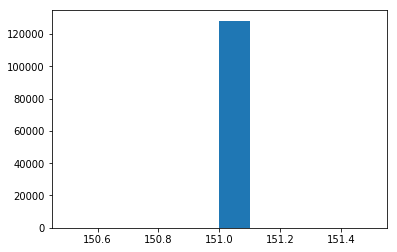

In [299]:
plt.hist([len(x) for x in reads])

In [312]:
len(quality_symbols)

95

In [313]:
quality_symbols[:15]

'!"#$%&\\\'()*+,-.'

In [316]:
qualities[100]

'AFFAFF=FFAFFFFFFFAFFFFFAFFFAFFFFFFFFFFFFFFFFFFFFFFFAFFFFFF/FFFFFFF6FAAFFFFFFFFF=FFFFFFFFFAFFFFFFFAFFF/FAFAF/FFFFF/FFF/FFFFFF=FFFFFFFFF/FFF/FFFFFFFFFFFF'

In [318]:
#  [sum([y in x for x in np.array(qualities)[mask]]) for y in quality_symbols]

In [232]:
p_str = repeat_to_re_pattern("(AAd)") 

In [233]:
p_str

'(AAd){e<=2}'

In [243]:
#p = re.compile("(AAAC){e<=2}")
p = re.compile(p_str)

In [244]:
[x.span() for x in re.finditer(p, "AAAA")]

[]

In [259]:
p_str = repeat_to_re_pattern(repeat,e=6)
p = re.compile(p_str)
print(p_str)

(GTTTTA[G|T]ATTAACTA[A|T][A|G]TGG[A|T]ATGTAAA[G|T]){e<=6}


In [260]:
[x.span() for x in re.finditer(p, reads[1])]

[(52, 84)]

In [261]:
reads[1][52:84]

'GGGTTTTAGATTAACTAAATGGAGATCGGAAG'

In [268]:
len(reads[1])

151

In [267]:
print_together(reads[1][54:84], repeat_clear)

G G
T T
T T
T T
T T
A A
G K
A A
T T
T T
A A
A A
C C
T T
A A
A W
A R
T T
G G
G G
A W
G A
A T
T G
C T
G A
G A
A A
A K


In [263]:
def print_together(s1, s2):
    for a,b in zip(s1, s2):
        print(a,b)

In [254]:
for  a,b in zip(reads[0], repeat[12:]):
    print(a, b)

A A
C C
T T
A A
T W
G R
T T
G G
G G
A )
A W
T A
G T
T G
A T
A A
A A
T A
G K


In [17]:
def repeat_matches(read, repeat, wildcards):
    pass

In [102]:
"|".join("ANB")

'A|N|B'

## import bio

In [154]:
from Bio.Seq import Seq
from Bio.Alphabet import generic_nucleotide
from Bio.Alphabet import IUPAC
nuc_seq = Seq("GATCGATGC", generic_nucleotide)
dna_seq = Seq("ACGTW", IUPAC.unambiguous_dna)

In [152]:
IUPAC.ambiguous_dna

'GATCRYWSMKHBVDN'

In [151]:
IUPAC_WILDCARDS

{'W': 'AT',
 'S': 'CG',
 'M': 'AC',
 'K': 'GT',
 'R': 'AG',
 'Y': 'CT',
 'B': 'CGT',
 'D': 'AGT',
 'H': 'ACT',
 'V': 'ACG',
 'N': 'ACGT'}

## RE

In [206]:
import regex as re

In [96]:
p = re.compile('a[d|b]c')

In [98]:
re.findall(p, 'aabddcx')

[]

## Mastering spades

In [9]:
import sys
sys.path.append("../spget/")

from importlib import reload

In [44]:
import spget as sp
sp = reload(sp)

In [50]:
raw = [x.split("\t")[2] for x in lines]

In [31]:
sp.get_parts(raw)

('ACTATGTGGAATGTAAATGAGGAGATTCAGACAGCGACTAAAAAGACTGATATAAAGTTTTAGATTAACTATATGGAATGTAAATAACTTTATATCTCCANTTGCATATCCATCTGATGAACGTTTTAGATTAACTATATGGAATGTAAAT',
 None,
 None)

In [34]:
path = "../data/clostr_test/fastq/test_1.fastq"
path = "../data/scripts/raw_data_clostr.fastq"
r_path = "../data/scripts/primers.txt"
rep = sp.load_repeats(r_path)

















1	GTTTTAKATTA(ACTAWRTGG)WATGTAAAK	2



loading repeats from ../data/scripts/primers.txt


In [37]:
a = {}
b = {}
sp.fill_parts(rep,a, b)


using following repeats sequences:
seq: GTTTTAKATTAACTAWRTGGWATGTAAAK id: 0 types: 1(|1) mismatches: 2
seq: ACTAWRTGGWATGTAAAK id: 1 types: 1( mismatches: 2
seq: GTTTTAKATTAACTAWRTGG id: 2 types: 1) mismatches: 2


In [45]:
sp.rc(raw)

'ATTTACATTCCATATAGTTAATCTAAAACGTTCATCAGATGGATATGCAANTGGAGATATAAAGTTATTTACATTCCATATAGTTAATCTAAAACTTTATATCAGTCTTTTTAGTCGCTGTCTGAATCTCCTCATTTACATTCCACATAGT'

In [53]:
for r in raw:
    print(sp.get_system_coords(sp.rc(r), a))

{}
{}
{}
{}
{}
{}
{}
{}


In [54]:
for r in raw:
    print(sp.get_system_coords(r, a))

{}
{}
{}
{}
{}
{}
{}
{}


In [56]:
from spget import * 

In [58]:
path = "../data/clostr_test/fastq/test_1.fastq"
path = "../data/scripts/raw_data_clostr.fastq"
r_path = "../data/scripts/primers.txt"
#rep = sp.load_repeats(r_path)

In [ ]:
repeats = load_repeats(r_path)
if not repeats:
    warn("no repeats loaded, exiting")
    exit(1)

all_mm = {}
id2primers = {}
fill_parts(repeats, all_mm, id2primers)


warn("\ntrimming...")

In [66]:
start_time = time.time()
for cnt, line in enumerate(lines, start = 1):
#     if cnt % time_each == 0 or cnt == args.time_first:
#         warn("\nprocessed " + str(cnt) + " reads in " + str_time(start_time) + " ...")
#     if of_parts and cnt % of_parts != part:
#         continue

    print(line)
    rec = list(map(lambda x: x.strip(), line.strip().split("\t")))
    rec += [""]
    print(rec)
    place, read_id, seq, qual = rec[0:4]

    rc_seq = rc(seq)
    rc_qual = qual[::-1]

    res = get_system_coords(seq, all_mm)
    res_rc = get_system_coords(rc_seq, all_mm)

#     both_dirs = res and res_rc
#     dump_read(place, read_id, res, seq, id2primers, both_dirs, "+", qual, args.dump_linked_ids)
#     dump_read(place, read_id, res_rc, rc_seq, id2primers, both_dirs, "-", qual, args.dump_linked_ids)

# warn("\nprocessed " + str(cnt) + " reads in " + str_time(start_time) + " ...")
# warn("\ndone...")

home	@MN00409:27:000H2KHTM:1:11102:17147:1044 1:N:0:11	ACTATGTGGAATGTAAATGAGGAGATTCAGACAGCGACTAAAAAGACTGATATAAAGTTTTAGATTAACTATATGGAATGTAAATAACTTTATATCTCCANTTGCATATCCATCTGATGAACGTTTTAGATTAACTATATGGAATGTAAAT	AFFAFFFFFF/FAFFFFFF6FFFFFFFFFFAFFFFFFFFFFFFFFFFF/FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF/FFFFFFFFFFFFF/FFF#FFFFFFFFFFFFFFFFFFFFF6FFFFFAFFFFFF//FAAAFA//FFAFFF

['home', '@MN00409:27:000H2KHTM:1:11102:17147:1044 1:N:0:11', 'ACTATGTGGAATGTAAATGAGGAGATTCAGACAGCGACTAAAAAGACTGATATAAAGTTTTAGATTAACTATATGGAATGTAAATAACTTTATATCTCCANTTGCATATCCATCTGATGAACGTTTTAGATTAACTATATGGAATGTAAAT', 'AFFAFFFFFF/FAFFFFFF6FFFFFFFFFFAFFFFFFFFFFFFFFFFF/FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF/FFFFFFFFFFFFF/FFF#FFFFFFFFFFFFFFFFFFFFF6FFFFFAFFFFFF//FAAAFA//FFAFFF', '']
home	@MN00409:27:000H2KHTM:1:11102:23264:1052 1:N:0:11	ACTATGTGGAATGTAAATCAGCCAAAAACTTCGAATTTGAACTAAAATGCGTGGGTTTTAGATTAACTAAATGGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCCAGTATCATCTCGTATGCCGTCTTCGGCTTGAAAAAAATAAG	AAAFFFFFFF/FFFFFFFFFFFFFFFFFFFFFFF/FFAFFFFFFFFFFFFFFFFFFF

In [74]:
def get_system_coords(seq, all_mm):
    out = defaultdict(list)
    for pat in all_mm:
        mm = all_mm[pat]["MM"]
        ins = all_mm[pat]["INS"]
        dl = all_mm[pat]["DEL"]
        pat_sys = all_mm[pat]["SYS"]
        pat_type = all_mm[pat]["TYPE"]
        pat_re_fuzzy = all_mm[pat]["RE_FUZZY"]
        pat_id = all_mm[pat]["ID"]
        found = fuzzy_find_seq(seq, pat, mm, ins, dl, pat_re_fuzzy, pat_type, pat_id)
        print(found)
        if found:
            for sys in pat_sys:
                out[sys] += found
    res = {}
    for sys in out:
        pruned = prune_matches(out[sys], sys)
        if pruned:
            res[sys] = pruned
    return res


In [83]:
def fuzzy_find_seq(where, what, mm, ins, dl, what_re_fuzzy, pat_type = None, pat_id = None):
    '''returns [(mm, from, to, substr)]'''
    if mm < 0:
        mm = 0
        
        
    print(what_re_fuzzy)
        
    print(where, "\n", what)
    out = []
    
    print(what_re_fuzzy.find(where, overlapped=True))
    positions = [(i.span()[0], i.span()[1], i[0], i.fuzzy_counts[0], i.fuzzy_counts[1], i.fuzzy_counts[2]) for i in what_re_fuzzy.finditer(where, overlapped=True)]

    positions = filter(lambda x: x[3] <= mm and x[4] <= ins and x[5] <= dl, positions)
    
    for frm, to, match, dist_mm, dist_ins, dist_del in positions:
        out.append((dist_mm + dist_ins + dist_del, frm, to, match, pat_type, pat_id))
    if not out:
        return None
    return out

In [89]:
re = all_mm['GTTTTAKATTAACTAWRTGGWATGTAAAK']['RE_FUZZY']

In [91]:
re

regex.Regex('(?:GTTTTAKATTAACTAWRTGGWATGTAAAK){s<=2,i<=0,d<=0}', flags=regex.V0)

In [90]:
re.findall(raw[0])

[]

In [84]:
get_system_coords(raw[0], all_mm)

regex.Regex('(?:GTTTTAKATTAACTAWRTGGWATGTAAAK){s<=2,i<=0,d<=0}', flags=regex.V0)
ACTATGTGGAATGTAAATGAGGAGATTCAGACAGCGACTAAAAAGACTGATATAAAGTTTTAGATTAACTATATGGAATGTAAATAACTTTATATCTCCANTTGCATATCCATCTGATGAACGTTTTAGATTAACTATATGGAATGTAAAT 
 GTTTTAKATTAACTAWRTGGWATGTAAAK
None
regex.Regex('(?:ACTAWRTGGWATGTAAAK){s<=2,i<=0,d<=0}', flags=regex.V0)
ACTATGTGGAATGTAAATGAGGAGATTCAGACAGCGACTAAAAAGACTGATATAAAGTTTTAGATTAACTATATGGAATGTAAATAACTTTATATCTCCANTTGCATATCCATCTGATGAACGTTTTAGATTAACTATATGGAATGTAAAT 
 ACTAWRTGGWATGTAAAK
None
regex.Regex('(?:GTTTTAKATTAACTAWRTGG){s<=2,i<=0,d<=0}', flags=regex.V0)
ACTATGTGGAATGTAAATGAGGAGATTCAGACAGCGACTAAAAAGACTGATATAAAGTTTTAGATTAACTATATGGAATGTAAATAACTTTATATCTCCANTTGCATATCCATCTGATGAACGTTTTAGATTAACTATATGGAATGTAAAT 
 GTTTTAKATTAACTAWRTGG
None


{}

In [ ]:
fuzzy_find_seq(raw[0], )

In [2]:
False and 'T' or 'F'

'F'